In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read marktwerte file

marktwerte = pd.read_csv("marktwerte.csv")
marktwerte.head()

,Spieler,Marktpreis,Datum
0,Aarón,8524900,2020-01-23 01:00:00
1,Aarón,8459655,2020-01-24 01:00:00
2,Aarón,8371633,2020-01-25 01:00:00
3,Aarón,8263016,2020-01-26 01:00:00
4,Aarón,8144400,2020-01-27 01:00:00


In [3]:
# List all individual Spieler and save the maximum number of tracked days

alive = marktwerte['Spieler'].value_counts()
max_days = np.max(alive)

In [4]:
# Save all Markpreise in an n x max_days matrix, where n is the number of players with full max_day support

markt_matrix = np.full((sum(alive == max_days), np.max(alive)), -1)

In [6]:
# Build maping from players to individuel IDs (row of Marktpreis matrix) and back from the ID to the name

# Mappings
spieler_to_id = {}
id_to_spieler = []

# Helpers
last_name = ""
i = -1
j = 0
for index, row in marktwerte.iterrows():
    if alive[row['Spieler']] == max_days:
        if last_name is not row['Spieler']:
            # New player found in list
            last_name = row['Spieler']
            i += 1
            spieler_to_id.setdefault(i, last_name)
            id_to_spieler.append(row['Spieler'])
            j = 0
        # Save Marktpreis for all days j for each player i
        markt_matrix[i, j] = row['Marktpreis']
        j += 1

In [7]:
# Generate training samples that contain n_days for each x_i and predict the n_days + 1 day as y_i

samples = []

n_samples = 10000
train_split = np.arange(450)
n_days = 14

x = np.empty((n_samples, n_days))
y = np.empty(n_samples)
for i in range(n_samples):
    ix = np.random.choice(train_split)
    start_ix = np.random.randint(max_days - n_days - 1)
    x[i] = markt_matrix[ix, start_ix:start_ix+n_days]
    y[i] = markt_matrix[ix, start_ix+n_days]

In [8]:
# Train a Linear Regression model with regularization loss and polynimial kernel expansion

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

reg = make_pipeline(PolynomialFeatures(2), Ridge(alpha=1.0))
reg = Ridge()
reg.fit(x, y);

Weston McKennie


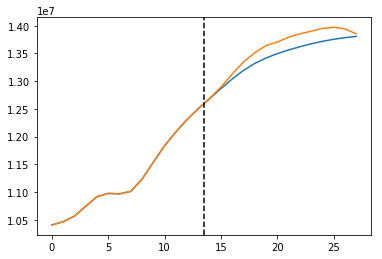

In [17]:
# Test the prediction for the player with index test_ix, where offset controls a shift in the
# days from which we want to predict the offset + n_days + 1 day

test_ix = 486
offset = 10
print(id_to_spieler[test_ix])

values = list(markt_matrix[test_ix, offset:n_days+offset])

for i in range(max_days - n_days - 1):
    pred = max(reg.predict([values[-n_days:]])[0], 500000)
    values.append(pred)

plt.plot(values[:2*n_days]);
plt.plot(markt_matrix[test_ix, offset:2*n_days + offset])
plt.axvline(x=n_days-0.5, linestyle='--', color='black')
plt.show()